In [1]:
from nemo.core import NeuralModuleFactory
from nemo.core import SimpleLossLoggerCallback
from nemo.core import EvaluatorCallback
from nemo.core import CheckpointCallback
from nemo.collections.nlp.data.datasets.text_classification_dataset import BertTextClassificationDataset
from nemo.collections.nlp.nm.data_layers.text_classification_datalayer import BertTextClassificationDataLayer
from nemo.collections.nlp.nm.trainables.common.huggingface.bert_nm import BERT
from nemo.collections.nlp.nm.trainables.common.sequence_classification_nm import SequenceClassifier
from nemo.backends.pytorch.common import CrossEntropyLossNM
from nemo.utils.lr_policies import get_lr_policy
from nemo.collections.nlp.callbacks.text_classification_callback import eval_iter_callback, eval_epochs_done_callback
from pytorch_transformers import BertTokenizer
import torch.nn.functional as f

import os
import json
import math
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = -1

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")
/home/eharper/github/ericharper/NeMo/nemo/collections/asr/audio_preprocessing.py:48: UserWarning: Could not import torchaudio. Some features might not work.
  warnings.warn('Could not import torchaudio. Some features might not work.')


In [2]:
%matplotlib inline

## Data Explore

The SST-2 dataset https://nlp.stanford.edu/sentiment/index.html is a standard benchmark for sentence classification and is part of the GLUE Benchmark: https://gluebenchmark.com/tasks. Please download and unzip the SST-2 dataset from GLUE.

In [3]:
data_dir = 'data/SST-2'
df = pd.read_csv(data_dir + '/train.tsv', sep='\t')
test_df = pd.read_csv(data_dir + '/test.tsv', sep='\t')

In [4]:
df.head()

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0


In [5]:
test_df.head()

,index,sentence
0,0,uneasy mishmash of styles and genres .
1,1,this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .
2,2,"by the end of no such thing the audience , like beatrice , has a watchful affection for the monster ."
3,3,director rob marshall went out gunning to make a great one .
4,4,"lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new ."


The dataset comes with a train file (labeled) and a test file (not labeled).  We will use part of the train file for model validation

In [6]:
# Split train to train and val and save to disk
np.random.seed(123)
train_mask = np.random.rand((len(df))) < .8
train_df = df[train_mask]
val_df = df[~train_mask]

In order to take advantage of NeMo's pre-built sentence classification data layer, the data must formatted as "sentence\tlabel" (sentence tab label).

In [7]:
# We will add a label column with all 0's (but they will not be used for anything).
test_df['label'] = 0

In [8]:
test_df = test_df[['sentence', 'label']]

In [9]:
test_df.head()

,sentence,label
0,uneasy mishmash of styles and genres .,0
1,this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .,0
2,"by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .",0
3,director rob marshall went out gunning to make a great one .,0
4,"lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new .",0


In [10]:
# Save new train, val, and test to disk
split_data_dir = data_dir + '/split'
if not os.path.exists(split_data_dir):
    os.makedirs(split_data_dir)
train_df.to_csv(split_data_dir + '/train.tsv', sep='\t', index=False)
val_df.to_csv(split_data_dir + '/eval.tsv', sep='\t', index=False)
test_df.to_csv(split_data_dir + '/test.tsv', sep='\t', index=False)

# Data Preprocessing

In order to use BERT or any other Deep NLP based model, we must first tokenize the data. Our tokenizer will map each word to an integer.

In [11]:
# Each pretrained BERT model comes with a Tokenizer
pretrained_bert_model = 'bert-base-uncased'
#pretrained_bert_model = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_bert_model)

In [12]:
max_seq_length = 64 # we will pad 0's to shorter sentences and truncate longer
sample_dataset = BertTextClassificationDataset(
split_data_dir + '/train.tsv',
max_seq_length,
tokenizer,
num_samples=100,
shuffle=False,
use_cache=False)

[NeMo I 2020-02-22 19:52:24 text_classification_dataset:99] data/SST-2/split/train.tsv: 53897
[NeMo I 2020-02-22 19:52:24 data_preprocessing:245] Min: 3 |                  Max: 38 |                  Mean: 13.13 |                  Median: 10.0
[NeMo I 2020-02-22 19:52:24 data_preprocessing:247] 75 percentile: 18.0
[NeMo I 2020-02-22 19:52:24 data_preprocessing:248] 99 percentile: 37.010000000000005
[NeMo I 2020-02-22 19:52:24 text_classification_dataset:135] 0 out of 100                         sentences with more than 64 subtokens.
[NeMo I 2020-02-22 19:52:24 text_classification_dataset:198] *** Example ***
[NeMo I 2020-02-22 19:52:24 text_classification_dataset:199] example_index: 0
[NeMo I 2020-02-22 19:52:24 text_classification_dataset:200] subtokens: [CLS] it ' s tough to watch , but it ' s a fantastic movie [SEP]
[NeMo I 2020-02-22 19:52:24 text_classification_dataset:201] sent_label: 1
[NeMo I 2020-02-22 19:52:24 text_classification_dataset:202] input_ids: 101 2009 1005 1055 7823

In [13]:
def print_tokenization(tokenizer, tokens):
    pad_counter = 0
    for token in tokens:
        if token == 0:
            pad_counter += 1
        if pad_counter > 4:
            break
        vocab_str = list(tokenizer.vocab.keys())[list(tokenizer.vocab.values()).index(token)]
        print(f'{vocab_str:15s} | {token}')

In [14]:
sample_idx = np.random.randint(0, len(sample_dataset))
tokens = sample_dataset[sample_idx][0]
print_tokenization(tokenizer, tokens)

[CLS]           | 101
easily          | 4089
the             | 1996
most            | 2087
thoughtful      | 16465
fictional       | 7214
examination     | 7749
[SEP]           | 102
[PAD]           | 0
[PAD]           | 0
[PAD]           | 0
[PAD]           | 0


## Neural Modules

In NeMo, everything is a Neural Module. Neural modules abstract data and neural network architectures. Where a deep learning framework like PyTorch or Tensorflow is used to combine neural network layers to create a neural network, NeMo is used to combine data and neural networks to create AI applications.

The Neural Module Factory will then manage the neural modules, taking care to flow data through the neural modules, and is also responsible for training (including mixed precision and distributed), logging, and inference.

In [15]:
# instantiate the neural module factory
log_dir = 'logs/' + pretrained_bert_model
checkpoint_dir = log_dir + '/checkpoints'
tensorboard_dir = log_dir + '/tensorboard'
nf = NeuralModuleFactory(log_dir=log_dir,
                                   checkpoint_dir=checkpoint_dir,
                                   tensorboard_dir=tensorboard_dir,
                                   create_tb_writer=True,
                                   add_time_to_log_dir=False,
                                   optimization_level='O1')

[NeMo W 2020-02-22 19:52:25 deprecated:68] Function ``_get_trainer`` is deprecated. It is going to be removed in the future version.


Pre-trained models will be automatically downloaded and cached.

In [16]:
# Pre-trained BERT
bert = BERT(pretrained_model_name=pretrained_bert_model)

# save bert model config for later use
bert_config_dict = bert.config.to_dict()

bert_model_config_path = log_dir + '/' + pretrained_bert_model + '_config.json'
with open(bert_model_config_path, 'w+') as json_file:
    json.dump(bert_config_dict, json_file)

Note here that the BERT models we are working with are massive. This gives our models a large capacity for learning that is needed to understand the nuance and complexity of natural language.

In [17]:
print(f'{pretrained_bert_model} has {bert.num_weights} weights')

bert-base-uncased has 109482240 weights


Here we define and instantiate the feed forward network that takes as input our BERT embeddings. This network will be used to output the sentence classifications.

In [18]:
# mlp classifier
bert_hidden_size = bert.local_parameters['hidden_size']

mlp = SequenceClassifier(hidden_size=bert_hidden_size, 
                                  num_classes=2,
                                  num_layers=2,
                                  log_softmax=False,
                                  dropout=0.1)

loss = CrossEntropyLossNM()

[NeMo W 2020-02-22 19:52:30 deprecated:68] Function ``local_parameters`` is deprecated. It is going to be removed in the 0.11 version.
/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [19]:
# Compared to the BERT model, the MLP is tiny.
print(f'MLP has {mlp.num_weights} weights')

MLP has 592130 weights


# Pipelines

Pipelines are used to define how data will flow the different neural networks. In this case, our data will flow through the BERT network and then the MLP network.

We also have different pipelines for training, validation, and inference data.  

For training data, we want it to be used for optimization so it must be shuffled and we also need to compute the loss.

For validation data, we won't use it for optimization but we want to know the loss.

And for inference data, we only want the final predictions coming from the model.

## Data Layers

We can gain a lot of efficiency by saving the tokenized data to disk. For future model runs we then don't need to tokenize every time.

In [20]:
use_cache = True

if pretrained_bert_model == 'bert-base-uncased':
    batch_size = 256
if pretrained_bert_model == 'bert-large-uncased':
    batch_size = 64

train_data = BertTextClassificationDataLayer(
    input_file=split_data_dir + '/train.tsv',
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    shuffle=True,
    num_samples=-1, # lower for dev, -1 for all dataset
    batch_size=batch_size,
    use_cache=use_cache,
)
val_data = BertTextClassificationDataLayer(
    input_file=split_data_dir + '/eval.tsv',
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    shuffle=False,
    num_samples=-1, # lower for dev, -1 for all dataset
    batch_size=batch_size,
    use_cache=use_cache,
)

[NeMo I 2020-02-22 19:52:30 text_classification_dataset:99] data/SST-2/split/train.tsv: 53897
[NeMo I 2020-02-22 19:53:10 data_preprocessing:245] Min: 3 |                  Max: 66 |                  Mean: 13.347663135239438 |                  Median: 10.0
[NeMo I 2020-02-22 19:53:10 data_preprocessing:247] 75 percentile: 18.0
[NeMo I 2020-02-22 19:53:10 data_preprocessing:248] 99 percentile: 44.0
[NeMo I 2020-02-22 19:53:10 text_classification_dataset:135] 3 out of 53897                         sentences with more than 64 subtokens.
[NeMo I 2020-02-22 19:53:10 text_classification_dataset:198] *** Example ***
[NeMo I 2020-02-22 19:53:10 text_classification_dataset:199] example_index: 0
[NeMo I 2020-02-22 19:53:10 text_classification_dataset:200] subtokens: [CLS] it ' s tough to watch , but it ' s a fantastic movie [SEP]
[NeMo I 2020-02-22 19:53:10 text_classification_dataset:201] sent_label: 1
[NeMo I 2020-02-22 19:53:10 text_classification_dataset:202] input_ids: 101 2009 1005 1055 782

In [21]:
train_input, train_token_types, train_attn_mask, train_labels = train_data()
val_input, val_token_types, val_attn_mask, val_labels = val_data()

## BERT Embeddings

In [22]:
train_embeddings = bert(input_ids=train_input,
                        token_type_ids=train_token_types,
                        attention_mask=train_attn_mask)
val_embeddings = bert(input_ids=val_input,
                        token_type_ids=val_token_types,
                        attention_mask=val_attn_mask)

## Inspect BERT Embeddings

If we want to inspect the data as it flows through our neural factory we can use the .infer method.  This method will give us the tensors without performing any optimization.

In [23]:
val_input_tensors = nf.infer(tensors=[val_input])

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
[NeMo I 2020-02-22 19:53:28 actions:719] Evaluating batch 0 out of 53
[NeMo I 2020-02-22 19:53:28 actions:719] Evaluating batch 5 out of 53
[NeMo I 2020-02-22 19:53:28 actions:719] Evaluating batch 10 out of 53
[NeMo I 2020-02-22 19:53:28 actions:719] Evaluating batch 15 out of 53
[NeMo I 2020-02-22 19:53:28 act

In [24]:
print(val_input_tensors[0][0][0].shape)

torch.Size([64])


In [25]:
print(val_input_tensors[0][0][0])

tensor([  101, 16691,  2008,  1996,  2472,  1997,  2107,  5365, 27858,  2015,
         2004, 16419,  2399,  2064,  2145,  2735,  2041,  1037,  2235,  1010,
         3167,  2143,  2007,  2019,  6832,  2813,  7361,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [26]:
%%time
val_embeddings_tensors = nf.infer(tensors=[val_embeddings])

[NeMo I 2020-02-22 19:53:30 actions:719] Evaluating batch 0 out of 53
[NeMo I 2020-02-22 19:53:31 actions:719] Evaluating batch 5 out of 53
[NeMo I 2020-02-22 19:53:31 actions:719] Evaluating batch 10 out of 53
[NeMo I 2020-02-22 19:53:32 actions:719] Evaluating batch 15 out of 53
[NeMo I 2020-02-22 19:53:33 actions:719] Evaluating batch 20 out of 53
[NeMo I 2020-02-22 19:53:33 actions:719] Evaluating batch 25 out of 53
[NeMo I 2020-02-22 19:53:34 actions:719] Evaluating batch 30 out of 53
[NeMo I 2020-02-22 19:53:35 actions:719] Evaluating batch 35 out of 53
[NeMo I 2020-02-22 19:53:35 actions:719] Evaluating batch 40 out of 53
[NeMo I 2020-02-22 19:53:36 actions:719] Evaluating batch 45 out of 53
[NeMo I 2020-02-22 19:53:36 actions:719] Evaluating batch 50 out of 53
CPU times: user 5.03 s, sys: 3.36 s, total: 8.39 s
Wall time: 8.51 s


In [27]:
# each word is embedded into bert_hidden_size space
# max_seq_len words are embedded
print(val_embeddings_tensors[0][0][0].shape)

torch.Size([64, 768])


In [28]:
val_embeddings_tensors[0][0].shape

torch.Size([256, 64, 768])

In [29]:
val_embeddings_tensors[0][0][0][:].shape

torch.Size([64, 768])

In [30]:
print(val_embeddings_tensors[0][0][1][:, 0])

tensor([-0.0411,  0.3532, -0.0894,  0.4343,  0.1857, -0.1037,  0.1186,  1.0778,
         1.6057,  0.7328, -0.0261,  0.3896, -0.1485,  0.2844,  0.1247,  0.3315,
        -0.0748,  0.9674,  0.6246,  1.8741,  0.2025, -0.8769,  1.2979,  0.1382,
         0.1296,  0.8687,  0.6109,  0.6801,  0.8896,  0.3682,  0.5614,  0.3335,
         0.6601,  0.5199,  0.2780,  0.2699,  0.2919,  0.5711,  0.6474,  0.6727,
         0.3360, -0.0213, -0.0820,  0.2346,  0.0613,  0.3278,  0.3369,  0.3224,
         0.0710, -0.1954,  0.4180, -0.0327,  0.1760,  0.5040,  0.0906,  0.5963,
         0.7837,  0.8575,  0.3593,  0.2210,  0.2633,  0.1899,  0.2107,  0.4541])


## Understanding and Visualizing BERT Embeddings

We are going to look at the BERT embeddings for the words (1-word sentences) in "data/SST-2/positive_negative.tsv". Since the BERT embeddings are 768 dimensional for BERT base and 1024 dimensional for BERT large, we'll first apply TSNE and reduce the embeddings to two dimensions.

In [31]:
spectrum_words = ['abysmal', 'apalling', 'dreadful', 'awful', 'terrible',
                  'very bad', 'really bad', 'rubbish', 'unsatisfactory',
                  'bad', 'poor', 'great', 'really good', 'very good', 'awesome'
                  'fantastic', 'superb', 'brilliant', 'incredible', 'excellent'
                  'outstanding', 'perfect']
spectrum_file = 'data/positive_negative.tsv'
with open(spectrum_file, 'w+') as f:
    f.write('sentence\tlabel')
    for word in spectrum_words:
        f.write('\n' + word + '\t0')

In [32]:
spectrum_df = pd.read_csv(spectrum_file, delimiter='\t')
print(spectrum_df.head())

   sentence  label
0  abysmal   0    
1  apalling  0    
2  dreadful  0    
3  awful     0    
4  terrible  0    


In [33]:
# positive negative spectrum
spectrum_data = BertTextClassificationDataLayer(
    input_file='data/positive_negative.tsv',
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    shuffle=False,
    num_samples=-1, # lower for dev, -1 for all dataset
    batch_size=batch_size,
    dataset_type=BertTextClassificationDataset
)

[NeMo I 2020-02-22 19:53:37 text_classification_dataset:99] data/positive_negative.tsv: 20
[NeMo I 2020-02-22 19:53:37 data_preprocessing:245] Min: 3 |                  Max: 6 |                  Mean: 3.85 |                  Median: 3.0
[NeMo I 2020-02-22 19:53:37 data_preprocessing:247] 75 percentile: 4.25
[NeMo I 2020-02-22 19:53:37 data_preprocessing:248] 99 percentile: 6.0
[NeMo I 2020-02-22 19:53:37 text_classification_dataset:135] 0 out of 20                         sentences with more than 64 subtokens.
[NeMo I 2020-02-22 19:53:37 text_classification_dataset:198] *** Example ***
[NeMo I 2020-02-22 19:53:37 text_classification_dataset:199] example_index: 0
[NeMo I 2020-02-22 19:53:37 text_classification_dataset:200] subtokens: [CLS] ab ##ys ##mal [SEP]
[NeMo I 2020-02-22 19:53:37 text_classification_dataset:201] sent_label: 0
[NeMo I 2020-02-22 19:53:37 text_classification_dataset:202] input_ids: 101 11113 7274 9067 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [34]:
spectrum_input, spectrum_token_types, spectrum_attn_mask, spectrum_labels = spectrum_data()

In [35]:
spectrum_embeddings = bert(input_ids=spectrum_input,
                        token_type_ids=spectrum_token_types,
                        attention_mask=spectrum_attn_mask)

In [36]:
spectrum_embeddings_tensors = nf.infer(tensors=[spectrum_embeddings])

[NeMo I 2020-02-22 19:53:40 actions:719] Evaluating batch 0 out of 1


In [37]:
spectrum_embeddings_tensors[0][0].shape

torch.Size([20, 64, 768])

In [38]:
spectrum_embeddings_tensors[0][0][:,0,:].shape

torch.Size([20, 768])

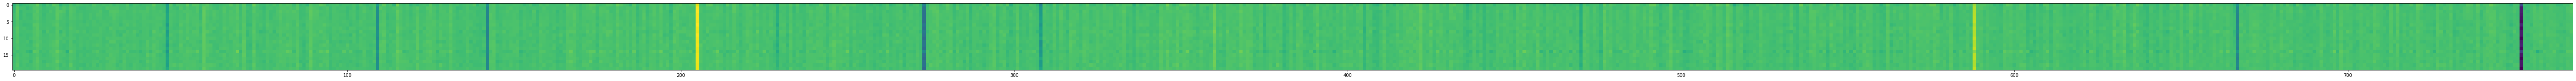

In [39]:
plt.figure(figsize=(100,100))
plt.imshow(spectrum_embeddings_tensors[0][0][:,0,:].numpy())

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 2.212268
[t-SNE] KL divergence after 100 iterations with early exaggeration: 35.360863
[t-SNE] KL divergence after 1000 iterations: 0.115844


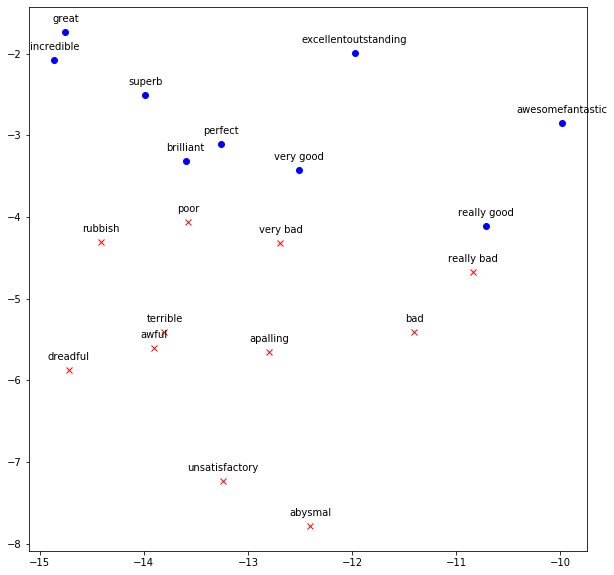

In [40]:
spectrum_activations = spectrum_embeddings_tensors[0][0][:,0,:].numpy()
tsne_spectrum = TSNE(n_components=2, perplexity=10, verbose=1, learning_rate=2,
                     random_state=123).fit_transform(spectrum_activations)

fig = plt.figure(figsize=(10,10))
plt.plot(tsne_spectrum[0:11, 0], tsne_spectrum[0:11, 1], 'rx')
plt.plot(tsne_spectrum[11:, 0], tsne_spectrum[11:, 1], 'bo')
for (x,y, label) in zip(tsne_spectrum[0:, 0], tsne_spectrum[0:, 1], spectrum_df.sentence.values.tolist() ):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

## Training Pipeline 

In order to optimize our network, we need to pass the embeddings through the MLP network and then compute the loss.

In [41]:
train_logits = mlp(hidden_states=train_embeddings)
val_logits = mlp(hidden_states=val_embeddings)

train_loss = loss(logits=train_logits, labels=train_labels)
val_loss = loss(logits=val_logits, labels=val_labels)

## Callbacks

Callbacks are used to record and log metrics and save checkpoints for the training and evaluation. We use callbacks to print to screen and also to tensorboard.




In [42]:
num_epochs = 3

num_gpus = 1

train_data_size = len(train_data)

steps_per_epoch = math.ceil(train_data_size / (batch_size * num_gpus))

train_callback = SimpleLossLoggerCallback(
    tensors=[train_loss, train_logits],
    print_func=lambda x: nf.logger.info(f'Train loss: {str(np.round(x[0].item(), 3))}'),
    tb_writer=nf.tb_writer,
    get_tb_values=lambda x: [["train_loss", x[0]]],
    step_freq=1)

eval_callback = EvaluatorCallback(
    eval_tensors=[val_logits, val_labels],
    user_iter_callback=lambda x, y: eval_iter_callback(
        x, y, val_data),
    user_epochs_done_callback=lambda x: eval_epochs_done_callback(
        x, f'{nf.work_dir}/graphs'),
    tb_writer=nf.tb_writer,
    eval_epoch=1,
    eval_step=steps_per_epoch)

# Create callback to save checkpoints
ckpt_callback = CheckpointCallback(
    folder=nf.checkpoint_dir,
    epoch_freq=1,
    step_freq=-1,
    checkpoints_to_keep=num_epochs)

In [43]:
lr_policy_fn = get_lr_policy('WarmupAnnealing',
                             total_steps=num_epochs * steps_per_epoch,
                             warmup_ratio=0.1)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
[NeMo I 2020-02-22 19:53:44 callbacks:179] Starting .....
[NeMo I 2020-02-22 19:53:44 callbacks:343] Found 2 modules with weights:
[NeMo I 2020-02-22 19:53:44 callbacks:345] BERT
[NeMo I 2020-02-22 19:53:44 callbacks:345] SequenceClassifier
[NeMo I 2020-02-22 19:53:44 callbacks:346] Total model parameters: 11007

[NeMo W 2020-02-22 19:53:44 callbacks:318] For module BERT, no file matches  in logs/bert-base-uncased/checkpoints
[NeMo W 2020-02-22 19:53:44 callbacks:319] Checkpoint folder logs/bert-base-uncased/checkpoints present but did not restore


[NeMo I 2020-02-22 19:53:44 callbacks:190] Starting epoch 0
[NeMo I 2020-02-22 19:53:48 callbacks:214] Step: 0


[NeMo W 2020-02-22 19:53:48 deprecated:68] Function ``logger`` is deprecated. It is going to be removed in the 0.11 version. Please use ``nemo.logging instead``


[NeMo I 2020-02-22 19:53:48 <ipython-input-42-1e26e9378cf5>:11] Train loss: 0.681
[NeMo I 2020-02-22 19:53:48 callbacks:229] Step time: 0.4149131774902344 seconds
[NeMo I 2020-02-22 19:53:48 callbacks:422] Doing Evaluation ..............................
[NeMo I 2020-02-22 19:53:58 text_classification_callback:57] Accuracy: 0.5591733571216176
[NeMo I 2020-02-22 19:53:58 text_classification_callback:64] Sampled preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
[NeMo I 2020-02-22 19:53:58 text_classification_callback:65] Sampled labels: [1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0]
[NeMo I 2020-02-22 19:53:58 callback_utils:88] Confusion matrix:
    [[  96 5854]
     [  76 7426]]
[NeMo I 2020-02-22 19:53:58 text_classification_callback:67]               precision    recall  f1-score   support
    
               0       0.56      0.02      0.03      5950
               1       0.56      0.99      0.71      7502
    
        accuracy                           0.56     13452
       macro avg    

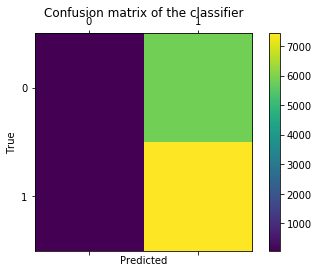

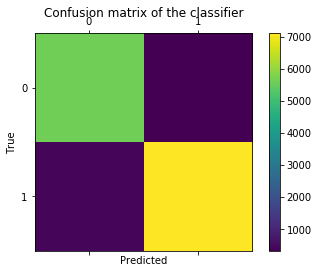

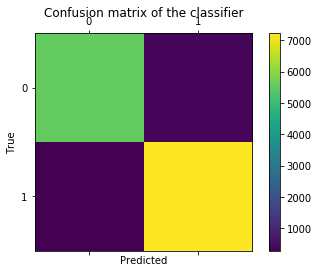

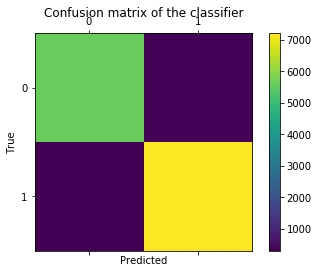

In [44]:
%%time
nf.train(tensors_to_optimize=[train_loss],
         callbacks=[train_callback, eval_callback, ckpt_callback],
         lr_policy=lr_policy_fn,
         optimizer='adam',
         optimization_params={'num_epochs': num_epochs, 'lr': 5e-5})

In [45]:
print(nf.tb_writer.get_logdir())

logs/bert-base-uncased/tensorboard


## Multi-Gpu Training

RESTART KERNEL BEFORE RUNNING THE MULTI-GPU TRAINING

In [1]:
%%time
num_gpus = 4
!python -m torch.distributed.launch --nproc_per_node=$num_gpus text_classification_with_bert.py \
--pretrained_bert_model 'bert-large-uncased' \
--data_dir 'data/SST-2/split' \
--dataset_name 'sst-2' \
--train_file_prefix 'train' \
--eval_file_prefix 'eval' \
--use_cache \
--batch_size 64 \
--max_seq_length 64 \
--num_gpus $num_gpus \
--num_epochs 3 \
--amp_opt_level 'O1' \
--work_dir 'logs_bert_large'

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")
/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")
/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")
/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: vid